# Goal

The objective of this notebook is to demonstrate and visualize the computation of the pareto frontier.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Optimizers.ParetoFrontier import ParetoFrontier
from mlos.Spaces import SimpleHypergrid, ContinuousDimension


Let's put toghether a very simple set of points, two of which are on the frontier, one is technically on the frontier, but is dominated by the first two, and several other points are strictly dominated.

Assuming we are trying to maximize both y1 and y2:
* Pareto efficient points (y1,y2): (1,2), (2,1)
* Points on the frontier line but dominated: (0.5, 2), (1,1), (2, 0.5)
* Strictly dominated points: (0.5, 0.5), (0.5, 1), (0.5, 1.5), (1, 0.5), (1.5, 0.5)

Text(0.5, 0, 'y1')

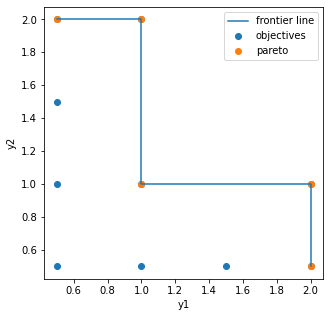

In [12]:
optimization_problem = OptimizationProblem(
    parameter_space=None,
    objective_space=SimpleHypergrid(
        name="objectives",
        dimensions=[
            ContinuousDimension(name='y1', min=0, max=5),
            ContinuousDimension(name='y2', min=0, max=5)
        ]
    ),
    objectives=[
        Objective(name='y1', minimize=False),
        Objective(name='y2', minimize=False)
    ]
)

objectives_df = pd.DataFrame(
    [
        [1, 2],
        [2, 1],
        [0.5, 2],
        [1, 1],
        [2, 0.5],
        [0.5, 0.5],
        [0.5, 1],
        [0.5, 1.5],
        [1, 0.5],
        [1.5, 0.5]
    ],
    columns=['y1', 'y2']
)

pareto_line = pd.DataFrame(
    [
        [0.5, 2],
        [1, 2],
        [1, 1],
        [2, 1],
        [2, 0.5],
    ],
    columns=['y1', 'y2']
)

pareto_frontier = ParetoFrontier(optimization_problem, objectives_df)
pareto_df = pareto_frontier.pareto_df

plt.figure(figsize=(5, 5))
plt.scatter(objectives_df['y1'], objectives_df['y2'], label="objectives")
plt.scatter(pareto_df['y1'], pareto_df['y2'], label="pareto")
plt.plot(pareto_line['y1'], pareto_line['y2'], label="frontier line")
plt.legend()
plt.ylabel('y2')
plt.xlabel('y1')

Text(0.5, 0, 'y1')

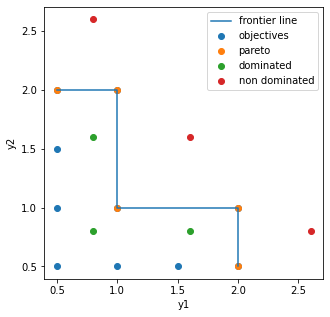

In [13]:
# Let's see if we can determine if a point is dominated or not.
#
dominated_points_df = pd.DataFrame({
    'y1': [0.8, 0.8, 1.6],
    'y2': [0.8, 1.6, 0.8]
})

non_dominated_points_df = pd.DataFrame({
    'y1': [0.8, 1.6, 2.6],
    'y2': [2.6, 1.6, 0.8]
})

plt.figure(figsize=(5, 5))
plt.scatter(objectives_df['y1'], objectives_df['y2'], label="objectives")
plt.scatter(pareto_df['y1'], pareto_df['y2'], label="pareto")
plt.scatter(dominated_points_df['y1'], dominated_points_df['y2'], label='dominated')
plt.scatter(non_dominated_points_df['y1'], non_dominated_points_df['y2'], label='non dominated')
plt.plot(pareto_line['y1'], pareto_line['y2'], label="frontier line")
plt.legend()
plt.ylabel('y2')
plt.xlabel('y1')

In [14]:
dominated_points_df.apply(lambda row: (row >= pareto_df).any(axis=1)).any(axis=1)


1    False
4    False
0    False
3    False
2    False
dtype: bool

In [15]:
non_dominated_points_df.apply(lambda row: (row >= pareto_df).any(axis=0))

,y1,y2
y1,False,False
y2,False,False
0,False,False
1,False,False
2,False,False


In [16]:
# dominated means that at least one point in the pareto is larger than the candidate point in every way.
def is_not_dominated(objectives_df, pareto_df):
    is_not_dominated = pd.Series([True for i in range(len(objectives_df.index))])
    for idx, pareto_row in pareto_df.iterrows():
        is_not_dominated = is_not_dominated & (objectives_df >= pareto_row).any(axis=1)
    return is_not_dominated

is_not_dominated(non_dominated_points_df, pareto_df)

0    True
1    True
2    True
dtype: bool

In [17]:
is_not_dominated(dominated_points_df, pareto_df)

0    False
1    False
2    False
dtype: bool

In [18]:
mixed = pd.concat([dominated_points_df, non_dominated_points_df], axis=0, ignore_index=True)
mixed

,y1,y2
0,0.8,0.8
1,0.8,1.6
2,1.6,0.8
3,0.8,2.6
4,1.6,1.6
5,2.6,0.8


In [20]:
assert not pareto_frontier.is_dominated(non_dominated_points_df).any()

In [22]:
assert pareto_frontier.is_dominated(dominated_points_df).all()

In [25]:
assert pareto_frontier.is_dominated(mixed).sum() == 3

In [27]:
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory, bayesian_optimizer_config_store
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory
from mlos.OptimizerEvaluationTools.SyntheticFunctions.Hypersphere import Hypersphere
from mlos.Spaces import ContinuousDimension, DiscreteDimension, Point, SimpleHypergrid

hypersphere_radius = 10

objective_function_config = Point(
    implementation=Hypersphere.__name__,
    hypersphere_config=Point(
        num_objectives=2,
        minimize='none',
        radius=hypersphere_radius
    )
)

objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config=objective_function_config)
optimization_problem = objective_function.default_optimization_problem
random_params_df = optimization_problem.parameter_space.random_dataframe(100)

# Let's randomly subsample 10% of points in random_params_df and make those points pareto optimal.
#
optimal_points_index = random_params_df.sample(
    frac=0.1,
    replace=False,
    axis='index'
).index

random_params_df.loc[optimal_points_index, ['radius']] = hypersphere_radius


dominated_params_df = random_params_df.loc[optimal_points_index].copy()
dominated_params_df['radius'] = 1
dominated_points_df = objective_function.evaluate_dataframe(dataframe=dominated_params_df)

non_dominated_params_df = random_params_df.loc[optimal_points_index].copy()
non_dominated_params_df['radius'] = 11
non_dominated_points_df = objective_function.evaluate_dataframe(dataframe=non_dominated_params_df)


objectives_df = objective_function.evaluate_dataframe(dataframe=random_params_df)
pareto_frontier = ParetoFrontier(
    optimization_problem=optimization_problem,
    objectives_df=objectives_df
)
pareto_df = pareto_frontier.pareto_df

In [29]:
assert pareto_frontier.is_dominated(dominated_points_df).all()

In [28]:
assert not pareto_frontier.is_dominated(non_dominated_points_df).any()

Text(0.5, 0, 'y0')

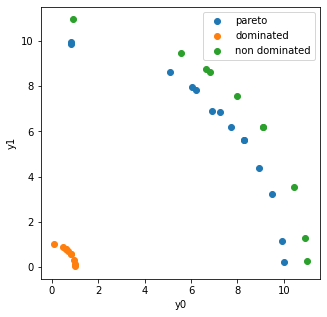

In [30]:
plt.figure(figsize=(5, 5))
#plt.scatter(objectives_df['y0'], objectives_df['y1'], label="objectives")
plt.scatter(pareto_df['y0'], pareto_df['y1'], label="pareto")
plt.scatter(dominated_points_df['y0'], dominated_points_df['y1'], label='dominated')
plt.scatter(non_dominated_points_df['y0'], non_dominated_points_df['y1'], label='non dominated')
plt.legend()
plt.ylabel('y1')
plt.xlabel('y0')

In [31]:
# So we have an optimization problem and some data. Let's create an optimizer, then hijack it's surrogate model to test the 
# MultiObjectivePrediction class.
optimizer = BayesianOptimizerFactory().create_local_optimizer(
    optimization_problem=optimization_problem
)

01/22/2021 01:47:54 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  37 -    create_local_optimizer() ] Optimizer config not specified. Using default.


In [32]:
# Let's give it some data to train on.
#
params_df = objective_function.parameter_space.random_dataframe(100)
objectives_df = objective_function.evaluate_dataframe(params_df)
optimizer.register(params_df, objectives_df)

In [34]:
# Now let's plot the existing pareto frontier, along with some predictions.
#
params_df, objectives_df, context_df = optimizer.get_all_observations()
pareto_frontier = ParetoFrontier(optimization_problem, objectives_df)
pareto_df = pareto_frontier.pareto_df
objectives_df['is_pareto'] = False
objectives_df.loc[pareto_df.index, 'is_pareto'] = True

multi_objective_random_forest = optimizer.surrogate_model




In [36]:
# Now let's generate some monte carlo samples from the predictive distribution. For that, we need our MultiObjectivePoiFunction
#
from mlos.Optimizers.ExperimentDesigner.UtilityFunctions.MultiObjectiveProbabilityOfImprovementUtilityFunction import MultiObjectiveProbabilityOfImprovementUtilityFunction, multi_objective_probability_of_improvement_utility_function_config_store
mo_poi_utility_function = MultiObjectiveProbabilityOfImprovementUtilityFunction(
    function_config = multi_objective_probability_of_improvement_utility_function_config_store.default,
    pareto_frontier=pareto_frontier,
    surrogate_model = multi_objective_random_forest
)

In [37]:
random_params_df = objective_function.parameter_space.random_dataframe(20)

In [38]:
import os
os.getpid()

871100

In [46]:
model_features_df = optimization_problem.construct_feature_dataframe(random_params_df)
multi_objective_predictions = multi_objective_random_forest.predict(model_features_df)

prediction_df = pd.DataFrame()
for objective_name, prediction in multi_objective_predictions:
    prediction_df[objective_name] = prediction.get_dataframe()['predicted_value']

# Let's prepare the data for monte carlo by making sure all predictions have a standard deviation available.
#
for _, objective_prediction in multi_objective_predictions:
    std_dev_column_name = objective_prediction.add_standard_deviation_column()

monte_carlo_samples_df = mo_poi_utility_function.create_monte_carlo_samples_df(multi_objective_predictions, 0, std_dev_column_name)
monte_carlo_samples_df['dominated'] = pareto_frontier.is_dominated(monte_carlo_samples_df)
dominated_samples_df = monte_carlo_samples_df[monte_carlo_samples_df['dominated']]
non_dominated_samples_df = monte_carlo_samples_df[~monte_carlo_samples_df['dominated']]

In [47]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=pareto_df['y0'], y=pareto_df['y1'], name='pareto', mode='markers'))
fig.add_trace(go.Scatter(x=prediction_df['y0'], y=prediction_df['y1'], name='prediction', mode='markers'))
fig.add_trace(go.Scatter(x=dominated_samples_df['y0'], y=dominated_samples_df['y1'], name='dominated', mode='markers'))
fig.add_trace(go.Scatter(x=non_dominated_samples_df['y0'], y=non_dominated_samples_df['y1'], name='non dominated', mode='markers'))
fig.show()